In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

##### RIPPL Curve

In [2]:
df = pd.read_csv('..\\Data\\Discharge_670.csv')

data = np.array([])
for column in df.columns[1:]:
    data = np.append(data, df[column].values)

df = pd.DataFrame(data, columns=["discharge"])
date = pd.date_range(start="1965-01-01", periods=len(data), freq="D")
df["Date"] = date
df = df.set_index("Date")

# df = df[df.index > "2000-01-01"]

display(df.head())

,discharge
Date,
1965-01-01,61.793513
1965-01-02,61.793513
1965-01-03,61.793513
1965-01-04,61.793513
1965-01-05,60.690057


,discharge,cum,demand_cum,shortage
Date,,,,
1,4.534098e+08,453.409768,609.277649,155.867881
2,5.117705e+08,965.180258,1218.555299,253.375040
3,5.512859e+08,1516.466109,1827.832948,311.366839
4,6.893799e+08,2205.846039,2437.110597,231.264558
5,8.089902e+08,3014.836234,3046.388247,31.552012


311.3668389313227


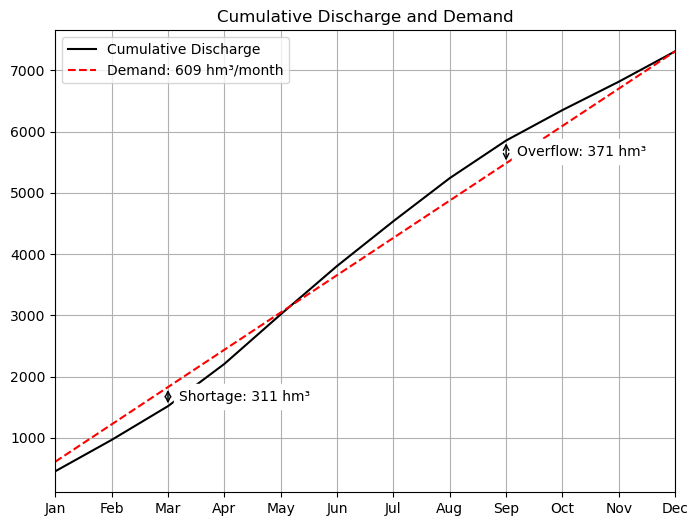

In [3]:
df_aten = df.resample("ME").mean()
df_aten = df_aten.groupby(df_aten.index.month).mean()
df_aten["discharge"] = df_aten["discharge"] * 3600 * 24 * 30.44 # hm³/month
df_aten["cum"] = df_aten["discharge"].cumsum() / 10**6  # in hm³
demand = df_aten["discharge"].mean()
df_aten["demand"] = demand  / 10**6
df_aten["demand_cum"] = df_aten["demand"].cumsum()
df_aten.drop(columns=["demand"], inplace=True)
df_aten["shortage"] = df_aten["demand_cum"] - df_aten["cum"]
display(df_aten.head())

shortage = df_aten["shortage"].max()
shortage_date = df_aten["shortage"].idxmax()
overflow = -df_aten["shortage"].min()
overflow_date = df_aten["shortage"].idxmin()
print(shortage)

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(df_aten.index, df_aten["discharge"], color="black", label="Daily Discharge")

ax.plot(df_aten.index, df_aten["cum"], color="black", label="Cumulative Discharge")
ax.plot(df_aten.index, df_aten["demand_cum"], "r--", label=f"Demand: {demand/10**6:.0f} hm³/month")
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
)
ax.annotate('',
            xy=(shortage_date, df_aten.loc[shortage_date, "cum"]),
            xytext=(shortage_date, df_aten.loc[shortage_date, "demand_cum"]),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1)
           )
ax.text(shortage_date + 0.2, (df_aten.loc[shortage_date, "cum"] + df_aten.loc[shortage_date, "demand_cum"]) / 2,
        f'Shortage: {shortage:,.0f} hm³', color='black', va='center', backgroundcolor='white')

ax.annotate('',
            xy=(overflow_date, df_aten.loc[overflow_date, "cum"]),
            xytext=(overflow_date, df_aten.loc[overflow_date, "demand_cum"]),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1)
           )
ax.text(overflow_date + 0.2, (df_aten.loc[overflow_date, "cum"] + df_aten.loc[overflow_date, "demand_cum"]) / 2,
        f'Overflow: {overflow:,.0f} hm³', color='black', va='center', backgroundcolor='white')  

ax.grid()
ax.legend()
ax.set_title('Cumulative Discharge and Demand')

plt.savefig('..\\figures\\discharge_demand.png', dpi=300)

#### Universal Soil Loss Equation

In [6]:
R = 7500        # [MJ mm / (ha h yr)]
K = 0.015       # [t ha h / (h ha MJ mm)]
C = 0.2         # [-]
LS = 8          # [-]
P = 1           # [-]
gamma_s = 0.1

E = R * K * C * LS * P  # [t/ha/yr]
print(f"Soil loss: {E:.2f} t/ha/yr")

DL = 50 # [yr]
A = 3260 * 100 # [ha]
rho = 2.6 # [t/m3]
vol_req_E = (E * A * DL / rho / 10**6) * gamma_s # [hm³]

print(f"Required volume for sediment retention: {vol_req_E:.2f} hm³")


Soil loss: 180.00 t/ha/yr
Required volume for sediment retention: 112.85 hm³


In [7]:
vol_req_tot = shortage + vol_req_E
print(f"Total required volume: {vol_req_tot:.2f} hm³")


Total required volume: 424.21 hm³
